In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input

# Data Collection

In [58]:
now = datetime.now()

start = datetime(now.year-10, now.month, now.day)
end = now
ticker = 'MSFT'

df = yf.download(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


# Data Exploration & Visualization

In [59]:
df.shape

(2515, 5)

In [60]:
df.isna().sum()

Price   Ticker
Close   MSFT      0
High    MSFT      0
Low     MSFT      0
Open    MSFT      0
Volume  MSFT      0
dtype: int64

In [61]:
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,MSFT,MSFT,MSFT,MSFT,MSFT
count,2515.000000,2515.000000,2515.000000,2515.000000,2.515000e+03
mean,226.926843,228.991635,224.661804,226.891772,2.739244e+07
std,140.621516,141.776098,139.389605,140.660183,1.236809e+07
min,43.009018,43.648426,42.475873,42.624729,5.855900e+06
25%,96.376305,97.499062,95.164636,96.560668,1.964120e+07
50%,219.858994,223.577967,217.797848,220.740800,2.426030e+07
75%,326.286667,329.351331,323.387182,326.396117,3.138110e+07
max,541.057373,553.502444,539.759814,553.283183,1.335030e+08


In [62]:
df.dtypes

Price   Ticker
Close   MSFT      float64
High    MSFT      float64
Low     MSFT      float64
Open    MSFT      float64
Volume  MSFT        int64
dtype: object

In [63]:
df = df.reset_index()
df.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,MSFT,MSFT,MSFT,MSFT,MSFT
0,2016-02-09,43.150089,43.990678,42.615966,42.922432,46740500
1,2016-02-10,43.526600,44.122015,43.360235,43.684210,38237000
2,2016-02-11,43.509094,43.876852,42.475873,42.624729,48878600
3,2016-02-12,44.218323,44.375933,43.561615,43.999420,34243300
4,2016-02-16,45.056137,45.056137,44.209516,44.888578,37291200


Text(0, 0.5, 'Close Price')

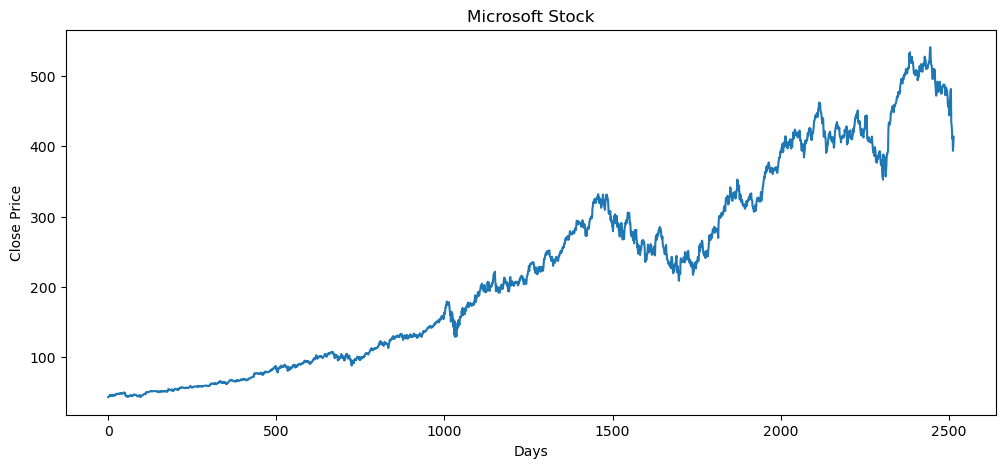

In [64]:
plt.figure(figsize=(12,5))
plt.plot(df.Close)
plt.title('Microsoft Stock')
plt.xlabel('Days')
plt.ylabel('Close Price')

# Feature Engineering

### 100 Days Moving Average

In [65]:
df['MA_100'] = df.Close.rolling(100).mean()

In [66]:
df.head(103)

Price,Date,Close,High,Low,Open,Volume,MA_100
Ticker,,MSFT,MSFT,MSFT,MSFT,MSFT,
0,2016-02-09,43.150089,43.990678,42.615966,42.922432,46740500,NaN
1,2016-02-10,43.526600,44.122015,43.360235,43.684210,38237000,NaN
2,2016-02-11,43.509094,43.876852,42.475873,42.624729,48878600,NaN
3,2016-02-12,44.218323,44.375933,43.561615,43.999420,34243300,NaN
4,2016-02-16,45.056137,45.056137,44.209516,44.888578,37291200,NaN
...,...,...,...,...,...,...,...
98,2016-06-29,44.882839,45.042691,44.225669,44.323357,31304000,NaN
99,2016-06-30,45.442322,45.557771,44.847319,45.042695,28527800,46.091176
100,2016-07-01,45.433441,45.930759,45.353515,45.406800,21400400,46.114009


Text(0, 0.5, 'Close Price')

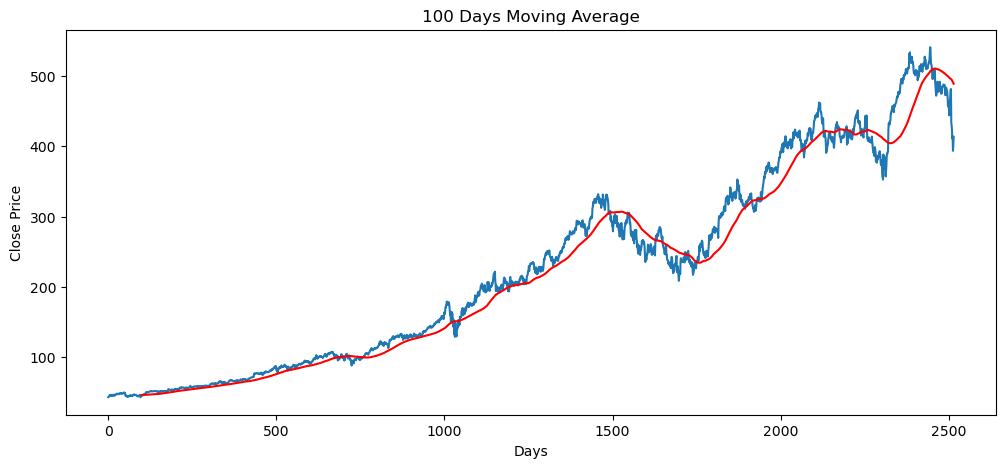

In [67]:
plt.figure(figsize=(12,5))
plt.plot(df.Close)
plt.plot(df['MA_100'], 'r')
plt.title('100 Days Moving Average')
plt.xlabel('Days')
plt.ylabel('Close Price')

In [68]:
df['MA_200'] = df.Close.rolling(200).mean()

Text(0, 0.5, 'Close Price')

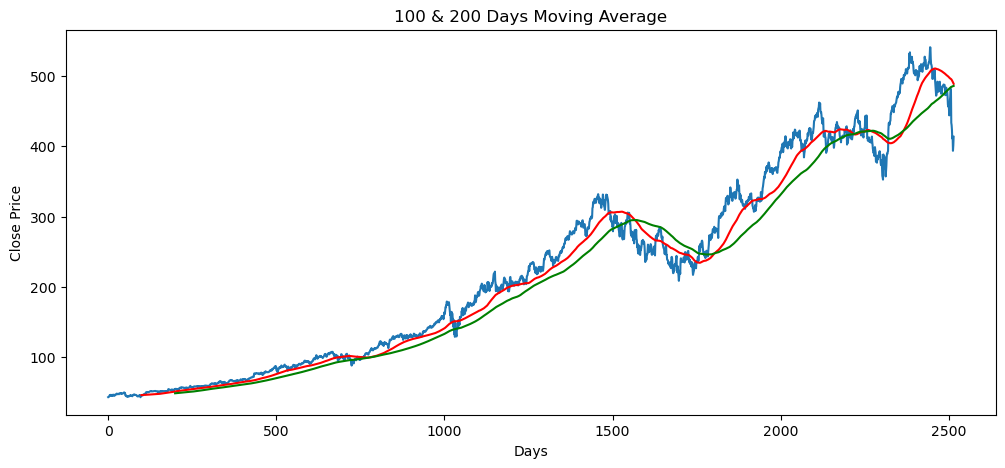

In [69]:
plt.figure(figsize=(12,5))
plt.plot(df.Close)
plt.plot(df['MA_100'], 'r')
plt.plot(df["MA_200"], 'g')
plt.title('100 & 200 Days Moving Average')
plt.xlabel('Days')
plt.ylabel('Close Price')

### Calculating % change in each trading session

In [70]:
df['Percentage Changed'] = df.Close.pct_change()

In [71]:
df[['Close', 'Percentage Changed']]

Price,Close,Percentage Changed
Ticker,MSFT,
0,43.150089,NaN
1,43.526600,0.008726
2,43.509094,-0.000402
3,44.218323,0.016301
4,45.056137,0.018947
...,...,...
2510,411.209991,-0.028722
2511,414.190002,0.007247
2512,393.670013,-0.049542


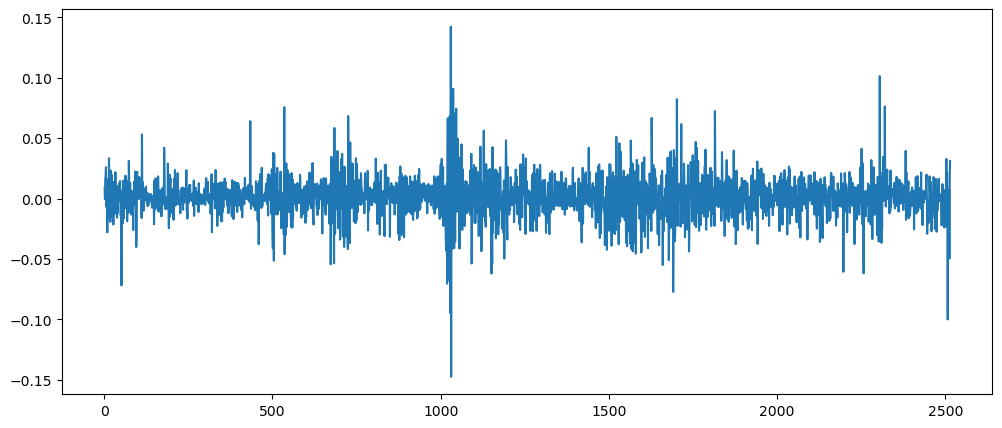

In [72]:
plt.figure(figsize=(12,5))
plt.plot(df["Percentage Changed"])

# Data Preprocessing

### Split data into training and testing sets.

In [73]:
data_training = pd.DataFrame(df.Close[0:int(len(df)*0.7)])
data_testing = pd.DataFrame(df.Close[int(len(df)*0.7): int(len(df))])

### Scale the data

In [74]:
scaler = MinMaxScaler(feature_range=(0,1))

In [75]:
data_training_array = scaler.fit_transform(data_training)

### Sequence Creation

In [76]:
x_train = []
y_train = []

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Model Creation

In [77]:
model = Sequential()
model.add(Input(shape=(100,1)))
model.add(LSTM(units=128, activation='tanh', return_sequences=True))
model.add(LSTM(units=64))
model.add(Dense(25))
model.add(Dense(1))

### Model training

In [78]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0113
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 6.0849e-04
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 4.7695e-04
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 5.3368e-04
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 5.7451e-04
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 4.7884e-04
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 4.4862e-04
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 4.9805e-04
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 4.1949e-04
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 5.6693e-04
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 4.1812e-04
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 4.1970e-04
Epoch 13/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 4.1139e-04
Epoch 14/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 3.5740e-04
Epoch 15/50
52/52 ━

In [79]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 100, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,625 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 352,859 (1.35 MB)

 Trainable params: 117,619 (459.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 235,240 (918.91 KB)

In [80]:
model.save('stock_prediction_model.keras')

In [81]:
past_100_days = data_training.tail(100)

In [82]:
past_100_days

Ticker,MSFT
1660,245.414246
1661,245.638229
1662,238.976730
1663,238.353439
1664,238.139175
...,...
1755,237.042587
1756,242.023499
1757,246.848129
1758,258.421387


In [83]:
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)

In [84]:
test_data_array = scaler.fit_transform(final_df)

In [86]:
x_test = []
y_test = []

for i in range(100, test_data_array.shape[0]):
    x_test.append(test_data_array[i-100: i])
    y_test.append(test_data_array[i, 0])

In [88]:
x_test, y_test = np.array(x_test), np.array(y_test)

# Make Predictions

In [89]:
y_predict = model.predict(x_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


In [90]:
y_predict = scaler.inverse_transform(y_predict.reshape(-1,1)).flatten()
y_test = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

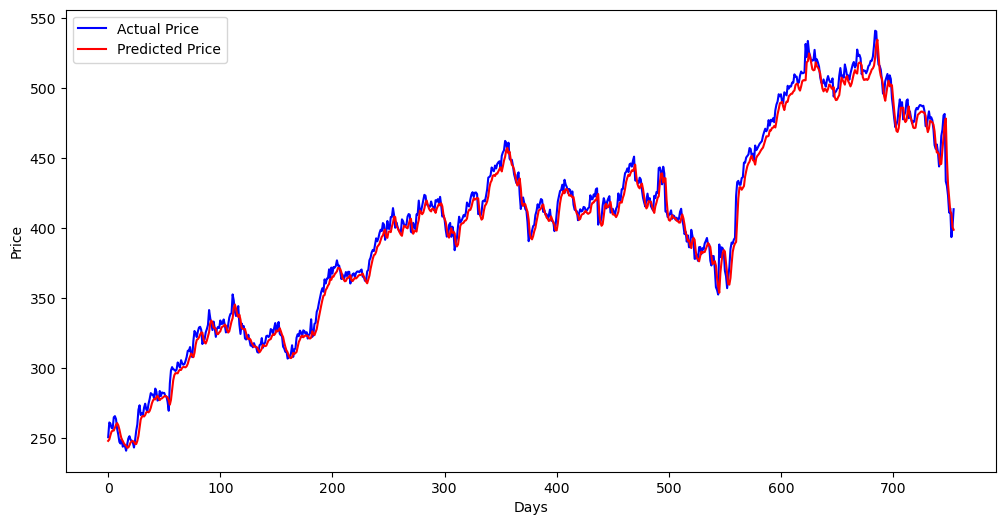

In [91]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b', label='Actual Price')
plt.plot(y_predict, 'r', label='Predicted Price')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()

### Model Evaluation

In [95]:
mse = mean_squared_error(y_test, y_predict)
print(f'Mean Squareed Error (MSE): {mse}')

Mean Squareed Error (MSE): 55.8598798190447


In [96]:
rmse = np.sqrt(mse)
print(f'Root Mean Squareed Error (RMSE): {rmse}')

Root Mean Squareed Error (RMSE): 7.473946736433482


In [101]:
r2 = r2_score(y_test, y_predict)
print(f'R-Squared Error (r2): {r2}')

R-Squared Error (r2): 0.9887785927906348
